**A 1D convolutional net with one GRU Layer in Keras.**

The data is directly fed into the net where it passes Conv + MaxPool to detect features, then it goes into a GRU + Dropout then activation.

It trains fast (less than 5 minutes on my GTX 970) and usually gets an F1 Score > 0.8 and can go up to 1.00 but i'd like to test it on more test data to check if it overfits.

Any comments appreciated.

In [1]:
import numpy as np
import pandas as pd
from numpy.random import seed
from tensorflow import set_random_seed

from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, precision_score, recall_score

from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Input, Conv1D, GRU, Flatten, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline  

Using TensorFlow backend.


This function is used to visualize if the model make good predictions on the skewed class.

In [2]:
# Display test set precision recall curve
def display_precision_recall_curve(reference, score):
    """
    Function to display the precision recall for a reference set.
    
    Arguments:
    reference -- the reference labels given for the set
    score -- the score computed 

    Returns:
    null
    """
    average_precision = average_precision_score(reference, score)
    precision, recall, _ = precision_recall_curve(reference, score)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

The simple model we will be using.

In [3]:
def model(input_shape):
    """
    Function creating the Exo_detector model.
    
    Arguments:
    input_shape -- shape of the input

    Returns:
    model -- a model instance in Keras
    """
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV + MaxPool layer to detect patterns
    X = Conv1D(32, kernel_size=10, strides=4)(X_input)
    X = MaxPooling1D(pool_size=4, strides=2)(X)
    X = Activation('relu')(X)
    
    # Step 2: GRU Layer
    X = GRU(192,return_sequences=True)(X)
    X = Flatten()(X)
    
    # Final sigmoid activation layer
    X = Dropout(0.5)(X)                                 
    X = BatchNormalization()(X)    
    X = Dense(1, activation="sigmoid")(X)

    model = Model(inputs= X_input, outputs = X)
    
    return model  

Importing the train then the test set.

Note that we have to reshape X to 3D (n, m , 1) because it is required by the first Conv1D Layer.

In [48]:
# get traincsv files
#train = pd.read_csv("../input/exoTrain.csv")
#train = pd.read_csv("./exoTrain.csv")
#nx, m = train.shape
#m -= 1

#y_train = train['LABEL'].values
#y_train -=1

#X_train = train.drop('LABEL', axis=1).values.reshape(nx, m, 1)

#print("Train set: \nNumber of examples={0}\nNumber of readings={1}".format(nx, m))

In [49]:
# get testcsv files
#test = pd.read_csv("./exoTest.csv")
#ny, my = test.shape
#my -= 1

#y_test = test['LABEL'].values
#print(y_train[0:40], y_test[0:10])
#y_test -= 1

#X_test = test.drop('LABEL',axis=1).values.reshape(ny, m, 1)

#assert m == my, "Error: train and test set have not the same number of timesteps"

#print("Train set: \nNumber of examples={0}\nNumber of readings={1}".format(ny, my))

In [22]:
#print(type(X_train), X_train.shape)
#print(type(X_test), X_test.shape)
#print(y_train[0:40], y_test[0:10])

<class 'numpy.ndarray'> (5087, 3197, 1)
<class 'numpy.ndarray'> (570, 3197, 1)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0] [1 1 1 1 1 0 0 0 0 0]


In [24]:
from sklearn.preprocessing import StandardScaler
from math import sqrt
#X_train = ((X_train - np.mean(X_train, axis=1)) / np.std(X_train, axis=1))
#X_test = ((X_test - np.mean(X_test, axis=1)) / np.std(X_test, axis=1))
train = pd.read_csv("./exoTrain.csv")
test = pd.read_csv("./exoTest.csv")
nx, m = train.shape
m -= 1

ny, my = test.shape
my -= 1

y_train = train['LABEL'].values
X_train = train.drop('LABEL', axis=1)
y_test = test['LABEL'].values
print(y_train[0:40], y_test[0:10])
y_test -= 1
y_train -=1

X_test = test.drop('LABEL',axis=1)

scaler = StandardScaler()
scaler = scaler.fit(X_train)
#print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)


X_train = X_train.values.reshape(nx, m, 1)

X_test = X_test.values.reshape(ny, m, 1)
print(type(X_train), X_train.shape)
print(type(X_test), X_test.shape)
print(y_train[0:40], y_test[0:10])

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 1 1] [2 2 2 2 2 1 1 1 1 1]
<class 'numpy.ndarray'> (5087, 3197, 1)
<class 'numpy.ndarray'> (570, 3197, 1)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0] [1 1 1 1 1 0 0 0 0 0]


In [25]:
from keras import backend as K
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Preparing the model and displaying a summary to check the output layers and trainable parameters.

In [35]:
# Set a seed for reproducibility
seed(42)
set_random_seed(42)

# prepare model
gru_model = model(input_shape = (m, 1))
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
gru_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',f1_m,precision_m, recall_m])

# check model shapes
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3197, 1)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 797, 32)           352       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 397, 32)           0         
_________________________________________________________________
activation_3 (Activation)    (None, 397, 32)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 397, 192)          129600    
_________________________________________________________________
flatten_3 (Flatten)          (None, 76224)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 76224)             0         
__________

I'm increasing the positive example weight because of the unbalanced set.

I also take a batch size of 128 so as to minimize the chance the minibatch has no positive example. Not sure if this is a good approach.

4 epochs are enough for the model to give good results sometimes, one more epoch may be necessary.

I'd like to have better metrics for this part.

In [36]:
# raise positive examples weight because of skewed classes and fit the model
class_weight = {0: 1., 1: 10}
gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=30, shuffle=True, class_weight=class_weight)

Train on 5087 samples, validate on 570 samples
Epoch 1/30
5087/5087 [==============================] - 16s 3ms/step - loss: 0.6986 - acc: 0.6652 - f1_m: 0.0203 - precision_m: 0.0106 - recall_m: 0.3187 - val_loss: 0.3172 - val_acc: 0.9596 - val_f1_m: 0.1382 - val_precision_m: 0.1123 - val_recall_m: 0.1796
Epoch 2/30
5087/5087 [==============================] - 15s 3ms/step - loss: 0.3726 - acc: 0.8657 - f1_m: 0.0814 - precision_m: 0.0454 - recall_m: 0.4907 - val_loss: 0.1694 - val_acc: 0.9965 - val_f1_m: 0.1996 - val_precision_m: 0.2246 - val_recall_m: 0.1796
Epoch 3/30
5087/5087 [==============================] - 16s 3ms/step - loss: 0.2602 - acc: 0.9269 - f1_m: 0.1343 - precision_m: 0.0830 - recall_m: 0.4737 - val_loss: 0.1167 - val_acc: 0.9982 - val_f1_m: 0.1996 - val_precision_m: 0.2246 - val_recall_m: 0.1796
Epoch 4/30
5087/5087 [==============================] - 15s 3ms/step - loss: 0.1963 - acc: 0.9599 - f1_m: 0.1917 - precision_m: 0.1298 - recall_m: 0.4320 - val_loss: 0.0918 - v

Time to evaluate on the trainning set.

Usually the AP=1.00, and the model makes no mistake which would indicate that the model overfits but we have the same kind of results with the test set.

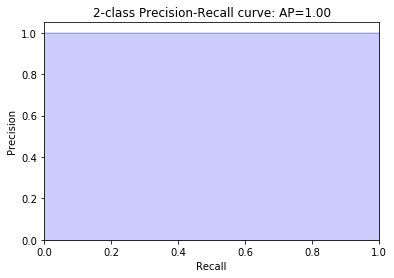

In [37]:
# Predict scores with trained model
y_train_score = gru_model.predict(X_train).flatten()
# Display precision_recall_curve for train set
display_precision_recall_curve(y_train, y_train_score)

The test set is usually nearly as good as the train with AP>0.8 and can go up to 1.0

I'd like to try it on some more data to see what I can do to improve it because we only have 5 positive examples in this set.

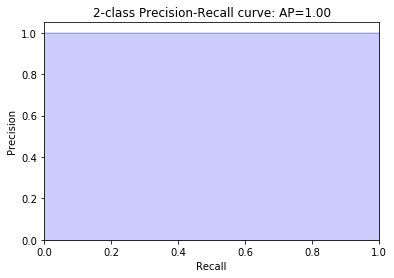

In [38]:
# Predict scores for test set
y_test_score = gru_model.predict(X_test).flatten()
# Display test set precision recall curve
display_precision_recall_curve(y_test, y_test_score)

I look for a threshold that gives me the best score I can get for this model.

Best Threshold 0.491, fscore 1.00000 , precision 1.00000 , recall 1.00000


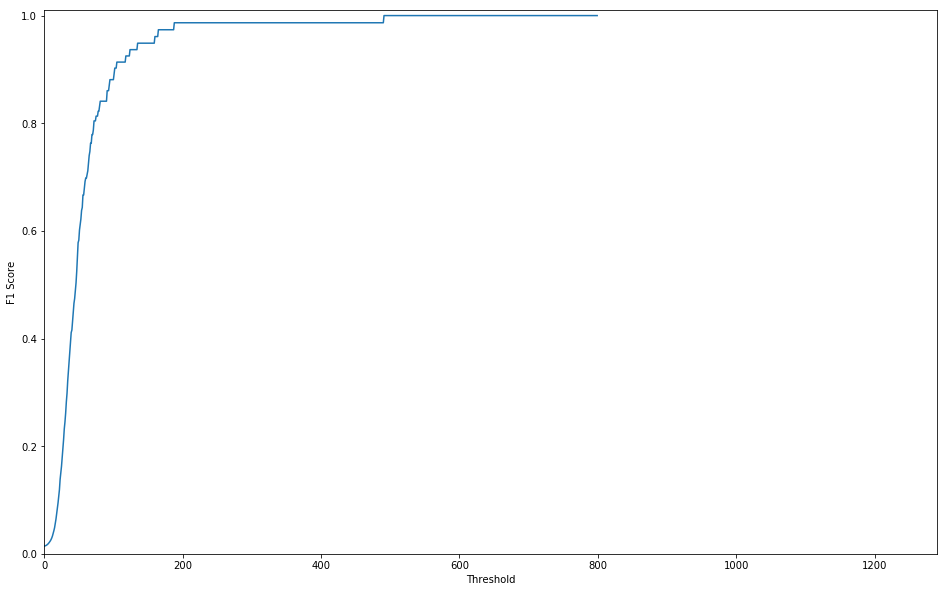

In [39]:
# Compute f_scores and choose best threshold value
f_scores_train = []
for i in range(800):
    f_scores_train.append(f1_score(y_train,np.where(y_train_score > i/1000,1,0)))
imax_train = np.argmax(f_scores_train)
y_max_train = np.where(y_train_score > imax_train/1000,1,0)

threshold_train = np.median((np.where(f_scores_train == f_scores_train[imax_train])[0]))/1000
print('Best Threshold {0:0.3f}, fscore {1:0.5f} , precision {2:0.5f} , recall {3:0.5f}'.format(imax_train/1000, f_scores_train[imax_train], precision_score(y_train, y_max_train), recall_score(y_train, y_max_train)))

plt.figure(figsize=(16,10))
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.xlim([0.0, threshold_train*2000])
plt.ylim([0.0, 1.01])
plt.plot(f_scores_train)

Best Threshold 0.130, fscore 1.00000 , precision 1.00000 , recall 1.00000


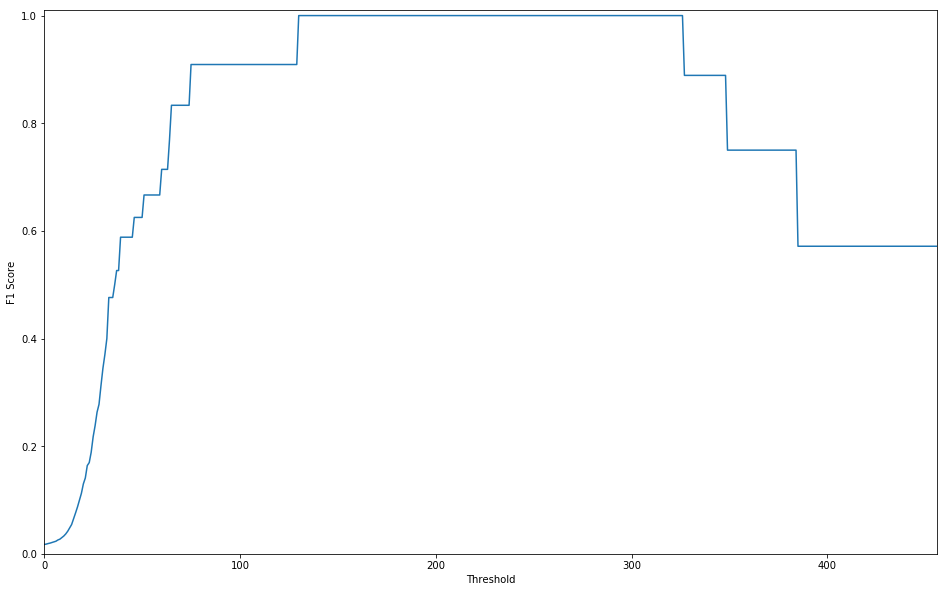

In [40]:
# Compute f_scores and choose best threshold value
f_scores = []
for i in range(800):
    f_scores.append(f1_score(y_test,np.where(y_test_score > i/1000,1,0)))
imax = np.argmax(f_scores)
y_max = np.where(y_test_score > imax/1000,1,0)

threshold = np.median((np.where(f_scores == f_scores[imax])[0]))/1000
print('Best Threshold {0:0.3f}, fscore {1:0.5f} , precision {2:0.5f} , recall {3:0.5f}'.format(imax/1000, f_scores[imax], precision_score(y_test, y_max), recall_score(y_test, y_max)))

plt.figure(figsize=(16,10))
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.xlim([0.0, threshold*2000])
plt.ylim([0.0, 1.01])
plt.plot(f_scores)

This will show which of the positives examples where correctly identified and which were not.
Most of the times, one sample is missing or they are all present but there is an extra false positive.

In [41]:
# Look at predicted positive labels:
threshold_train=imax_train/1000
y_hat = np.where(y_test_score>=threshold_train,1,0)
print("F1_Score {0:4f} at threshold {1:4f}\n".format(f1_score(y_test, y_hat), threshold_train))

print("Predicted ExoPlanet samples", np.where(y_test_score>=threshold_train)[0])
print("Actual ExoPlanet Samples", np.where(y_test==1)[0])
print(y_test_score[0])



F1_Score 0.571429 at threshold 0.491000

Predicted ExoPlanet samples [1 3]
Actual ExoPlanet Samples [0 1 2 3 4]
0.3260732


In [47]:
#Using threshold as 0.9
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve
y_hat = gru_model.predict(X_test)[:,0]
y_pred = np.where(y_hat > threshold_train,1.,0.)

#y_pred = gru_model.predict_classes(X_test)


# accuracy: (tp + tn) / (p + n)
print('Accuracy:', accuracy_score(y_test, y_pred))
# f1: 2 tp / (2 tp + fp + fn)
print('F1 score:', f1_score(y_test, y_pred))
# recall: tp / (tp + fn)
print('Recall:', recall_score(y_test, y_pred))
# precision tp / (tp + fp)
print('Precision:', precision_score(y_test, y_pred))
#cohen's kappa
print('Cohens Kappa :', cohen_kappa_score(y_test, y_pred))
#AUC score
print('ROC AUC Score:', roc_auc_score(y_test, y_pred))
#Classification report
print('\n clasification report:\n', classification_report(y_test,y_pred))
#Confusion matrix
print('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))

AttributeError: 'Model' object has no attribute 'predict_classes'

In [43]:
#y_train_pred = model_two.predict_classes(x_train)[:,0]
y_train_hat = gru_model.predict(X_train)[:,0]
y_train_pred = np.where(y_train_hat > 0.9,1.,0.)
print('Accuracy:', accuracy_score(y_train, y_train_pred))
print('F1 score:', f1_score(y_train, y_train_pred))
print('Recall:', recall_score(y_train, y_train_pred))
print('Precision:', precision_score(y_train, y_train_pred))
print('Cohens Kappa :', cohen_kappa_score(y_train, y_train_pred))
print('ROC AUC Score:', roc_auc_score(y_train, y_train_pred))
print('\n clasification report:\n', classification_report(y_train, y_train_pred))
print('\n confussion matrix:\n',confusion_matrix(y_train, y_train_pred))

Accuracy: 0.9996068409671712
F1 score: 0.9722222222222222
Recall: 0.9459459459459459
Precision: 1.0
Cohens Kappa : 0.9720243954750684
ROC AUC Score: 0.972972972972973

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5050
           1       1.00      0.95      0.97        37

    accuracy                           1.00      5087
   macro avg       1.00      0.97      0.99      5087
weighted avg       1.00      1.00      1.00      5087


 confussion matrix:
 [[5050    0]
 [   2   35]]
